## Description

**Enunciado**:

Los insectos nocturnos representan uno de los grupos más diversos de organismos, por lo que es de suma importancia estudiarlos.

Es por ello que un grupo de prestigiosos entomólogos han construido un ecosistema aislado con múltiples especies para poder estudiarlos en mayor detalle. Para este estudio están diseñando un sistema de sensores para poder trackear de forma automática las dinámicas y hábitos de estos insectos.

Este dataset contiene datos de las mediciones de los sensores, el tiempo de las mediciones y el tipo de insecto identificado.


El dataset **'train.csv'** contiene las siguientes variables:

Hour: Hora a la que se ha hecho la medición.

Minutes: Minutos en los que se ha realizado la medición.

Sensor_alpha: Posición del insecto al sensor alpha.

Sensor_beta: Posición del insecto al sensor beta.

Sensor_gamma: Posición del insecto al sensor gamma.

Sensor_alpha_plus: Posición del insecto al sensor alpha+.

Sensor_beta_plus: Posición del insecto al sensor beta+.

Sensor_gamma_plus: Posición del insecto al sensor gamma+.

Insect: Categoría de insecto.

    0 -> Lepidoptero 

    1 -> Himenoptera

    2 -> Diptera




## Task and target of the exercise

Tienes que entregar el **link de tu repositorio de Github/Gitlab**.

Este tiene que tener:

El código con el que has realizado el EDA y el modelo predictivo.

Un **archivo 'results.csv'** con las predicciones de tu algoritmo al meterle como input el dataset test_x. Este archivo con los resultados ha de tener una columna con el índice y otra con las predicciones del 'Insect'.

In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.decomposition import PCA
import lightgbm
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
#import joblib

import dill as pickle


import pandas as pd
from pycaret.classification import * 
#from ngboost import NGBClassifier
#from ngboost.distns import Bernoulli
 
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.metrics import f1_score, confusion_matrix
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

%matplotlib inline   

# Exploratory Data Analysis

## Data acquisition & preliminary study 

In [2]:
insect_df=pd.read_csv ('train.csv',index_col=0)

In [3]:
insect_df.describe()

,Hour,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus,Insect
count,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000
mean,19.598914,29.405942,0.477171,-29.974117,-5.624690,7.188060,-0.757901,-0.554533,0.595772
std,3.507008,17.375830,99.294856,133.095125,115.871391,122.327980,100.039477,100.535951,0.661604
min,1.000000,0.000000,-404.898823,-656.272666,-448.478039,-437.205393,-387.567443,-374.961689,0.000000
25%,19.000000,14.000000,-68.573905,-116.060383,-83.508747,-79.496687,-68.061596,-69.652647,0.000000
50%,21.000000,29.000000,-0.287447,-36.171567,-1.217606,-1.133567,-0.444124,0.027128,0.000000
75%,21.000000,44.000000,66.480795,56.637778,76.870277,93.285286,66.181909,67.838524,1.000000
max,23.000000,59.000000,351.256221,518.395878,378.349287,462.556319,345.279240,363.682391,2.000000


In [4]:
insect_df.isnull().sum()

Hour                 0
Minutes              0
Sensor_alpha         0
Sensor_beta          0
Sensor_gamma         0
Sensor_alpha_plus    0
Sensor_beta_plus     0
Sensor_gamma_plus    0
Insect               0
dtype: int64

There are no null values.

In [5]:
#Hour and minute columns are unified by converting hour to minutes and adding it to the minute column:
insect_df['Minutes']=(insect_df['Hour']*60)+insect_df['Minutes']
insect_df.drop('Hour',axis=1,inplace=True)
insect_df.describe()

,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus,Insect
count,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000
mean,1205.340808,0.477171,-29.974117,-5.624690,7.188060,-0.757901,-0.554533,0.595772
std,210.956044,99.294856,133.095125,115.871391,122.327980,100.039477,100.535951,0.661604
min,61.000000,-404.898823,-656.272666,-448.478039,-437.205393,-387.567443,-374.961689,0.000000
25%,1177.000000,-68.573905,-116.060383,-83.508747,-79.496687,-68.061596,-69.652647,0.000000
50%,1272.000000,-0.287447,-36.171567,-1.217606,-1.133567,-0.444124,0.027128,0.000000
75%,1305.000000,66.480795,56.637778,76.870277,93.285286,66.181909,67.838524,1.000000
max,1439.000000,351.256221,518.395878,378.349287,462.556319,345.279240,363.682391,2.000000


In [6]:
insect_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7001 entries, 0 to 7000
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Minutes            7001 non-null   int64  
 1   Sensor_alpha       7001 non-null   float64
 2   Sensor_beta        7001 non-null   float64
 3   Sensor_gamma       7001 non-null   float64
 4   Sensor_alpha_plus  7001 non-null   float64
 5   Sensor_beta_plus   7001 non-null   float64
 6   Sensor_gamma_plus  7001 non-null   float64
 7   Insect             7001 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 492.3 KB


All columns are numerical values. However, the insect column should be consideres as categorical (as label column).

## Data Visualization

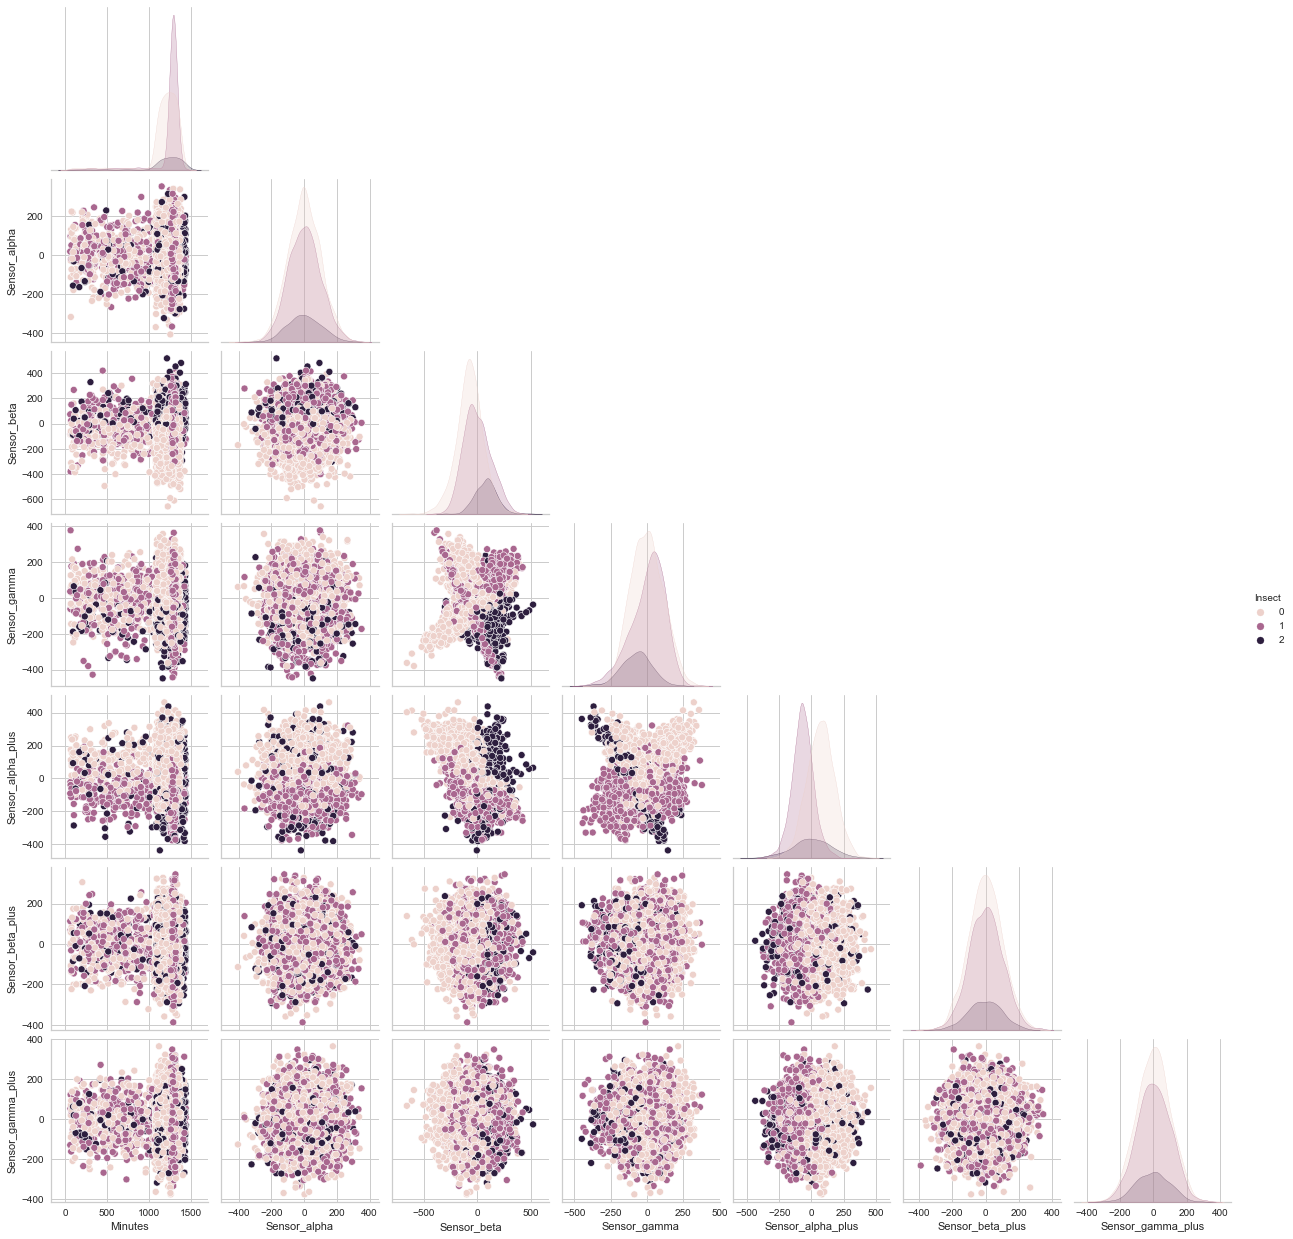

In [7]:
sns.pairplot(insect_df,hue='Insect',corner=True)

From previous graph, several information can be extracted from the original data set:
* There is special patern for each type of insect showing differential graphical clusters.
* Data has mostly a Gaussian distribution.
* There is no need to transform time values to cyclical because data distribution (not allocated in the extremes of the range). 
    

To visualize the diferent insect's types in a graphical mode, the dimension of the parameters is reduced to 2 by Principal Component Analysis. 

In [8]:
pca = PCA(n_components = 2)
insect_df_no_target= insect_df.copy()
insect_df_no_target.drop('Insect',inplace=True,axis=1)
pca_insects = pca.fit_transform(insect_df_no_target)
pca_insects_df = pd.DataFrame(data=pca_insects, 
                            columns = ['Component 1', 'Component 2']
)


#per donar color
labels=np.array(insect_df.Insect)
LABEL_COLOR_MAP = {0 : 'r', 1 : 'b', 2 : 'y', 3 : '%killbgscripts'}
label_color = [LABEL_COLOR_MAP[l] for l in labels]

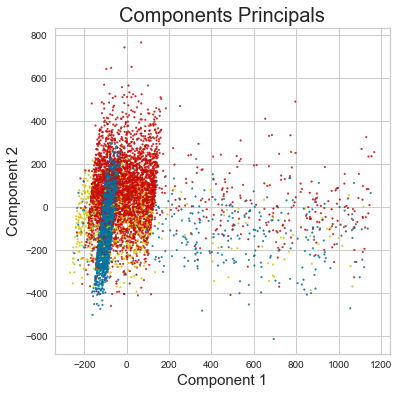

In [9]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize=15)
ax.set_ylabel('Component 2', fontsize=15)
ax.set_title('Components Principals', fontsize=20)

ax.scatter(x= pca_insects_df['Component 1'], y=pca_insects_df['Component 2'],
           c=label_color,s=3,alpha=0.9)
plt.show()

Clearly, there is paterns than define each class of instect, and it can be used to generate a model to predict which class of insect is based on his movement pattern.

## Data Engineering

In [10]:
# Split the dataframe between the label column and  columns which contains the info to label the insects:
X=insect_df.copy()
X.drop('Insect', axis=1, inplace=True)
y=insect_df.Insect #label

Text(0, 0.5, '# of instances')

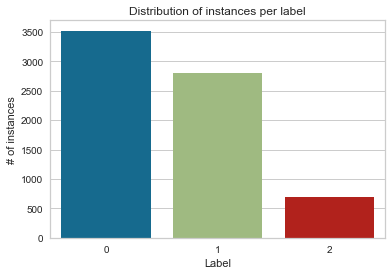

In [13]:
#Class distribution checking
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

Number of instances for each class is unbalanced. It should be considered in the evaluation of model's performance. Specifically, it has to be checked the results with the minoritary class. F1 score is a good metric to check recall and accuracy

To improve the model performance data will be standarized taking special care on avoiding information leakage from the test sample. Working with Pycaret and pipelines ensure a proper prepocessing of data.

# Model development by Machine Learning

## Initial Screening of Classification Models by Pycaret

In [14]:
def scoring_f1(y_test,X_test,method,model_name): #generation of different f1 metrics
    score_list=[]
    for i in [None, 'micro', 'macro', 'weighted']:
        score_list.append(i)
        
        f1score=f1_score(y_test, 
                         method.predict(X_test),
                         average= i
        )
        if i!=None:
            score_list.append(f1score)
        else:
            score_list.append(list(f1score))
    score_list.pop(0)
    df = f1_df(score_list,model_name)
    return df      

In [15]:
def f1_df (score_list, model_name): #dataframe generator for f1 metrics
    df = pd.DataFrame({'Model': [model_name],
                    'F1_ind_L0':  [round(score_list[0][0], 3)], 
                    'F1_ind_L1':  [round(score_list[0][1], 3)], 
                    'F1_ind_L2':  [round(score_list[0][2], 3)],
                    'F1_averg_micro' : [round(score_list[2], 3)], 
                    'F1_averg_macro' : [round(score_list[4], 3)], 
                    'F1_averg_weighted' : [round(score_list[6],3)],
                    },
                     index = None)
    return df

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,  
                                                    stratify=y,
)

In [17]:
#setting the experiment

experiment = setup(insect_df, 
                   target='Insect'
)  

,Description,Value
0,session_id,4770
1,Target,Insect
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(7001, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [18]:
#show the best model and their statistics

best_model = compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9043,0.9699,0.8330,0.9032,0.9014,0.8320,0.8331,0.2780
gbc,Gradient Boosting Classifier,0.8933,0.9650,0.8139,0.8930,0.8896,0.8118,0.8135,2.1740
rf,Random Forest Classifier,0.8906,0.9637,0.7999,0.8919,0.8857,0.8060,0.8082,0.6230
et,Extra Trees Classifier,0.8827,0.9632,0.7909,0.8853,0.8776,0.7915,0.7940,0.4890
dt,Decision Tree Classifier,0.8363,0.8626,0.7756,0.8373,0.8365,0.7173,0.7176,0.0410
ada,Ada Boost Classifier,0.8343,0.9031,0.7220,0.8270,0.8279,0.7073,0.7089,0.2090
knn,K Neighbors Classifier,0.8229,0.9073,0.7167,0.8303,0.8149,0.6850,0.6896,0.1080
qda,Quadratic Discriminant Analysis,0.7620,0.8641,0.6849,0.7733,0.7590,0.5799,0.5840,0.0190
lr,Logistic Regression,0.7412,0.8433,0.6249,0.7381,0.7316,0.5374,0.5403,1.4830
lda,Linear Discriminant Analysis,0.7343,0.8405,0.6293,0.7374,0.7268,0.5262,0.5292,0.0190


The model with best results in this first exploratory analysis is Light Gradient Boosting Machine. However, let's check the tunning for the top three models with 2 methodologies: Pycaret and GridSearchCV.

## Tuning hyperparameters

### Gradient Boosting Classifier

#### Tuned with Pycaret

In [22]:
gbc=create_model('gbc')	# Gradient Boosting Classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8939,0.9701,0.8185,0.8921,0.8911,0.8132,0.8141
1,0.9041,0.9673,0.8469,0.9046,0.9025,0.8312,0.8321
2,0.8653,0.9489,0.7545,0.8640,0.8579,0.7601,0.7627
3,0.9041,0.9638,0.8382,0.9030,0.9018,0.8318,0.8327
4,0.8918,0.9596,0.8126,0.8935,0.8883,0.8090,0.8107
5,0.8878,0.9629,0.8200,0.8901,0.8854,0.8025,0.8041
6,0.8939,0.9673,0.8160,0.8931,0.8905,0.8146,0.8171
7,0.9061,0.9751,0.8339,0.9042,0.9035,0.8353,0.8361
8,0.9020,0.9706,0.8246,0.9047,0.8989,0.8265,0.8284
9,0.8837,0.9642,0.7735,0.8802,0.8760,0.7941,0.7967


In [23]:
gbc_tuned=tune_model(gbc, 
                     optimize = 'F1'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9000,0.9687,0.8390,0.8986,0.8984,0.8247,0.8253
1,0.9041,0.9740,0.8424,0.9037,0.9022,0.8314,0.8322
2,0.8816,0.9514,0.7887,0.8813,0.8767,0.7907,0.7928
3,0.8939,0.9647,0.8248,0.8935,0.8913,0.8133,0.8143
4,0.8980,0.9655,0.8338,0.8997,0.8957,0.8207,0.8222
5,0.8918,0.9634,0.8332,0.8909,0.8902,0.8108,0.8114
6,0.9082,0.9692,0.8538,0.9107,0.9066,0.8404,0.8433
7,0.8918,0.9752,0.8220,0.8897,0.8897,0.8103,0.8110
8,0.9102,0.9729,0.8419,0.9123,0.9078,0.8417,0.8431
9,0.8816,0.9641,0.7827,0.8754,0.8765,0.7927,0.7938


In [24]:
gbc_PyC_df= scoring_f1(y_test,
                           X_test,
                           gbc,
                           'gbc_PyC')

In [25]:
gbc_PyC_tuned_df= scoring_f1(y_test,
                           X_test,
                           gbc_tuned,
                           'gbc_PyC_tuned')

In [26]:
gbc_PyC_df

,Model,F1_ind_L0,F1_ind_L1,F1_ind_L2,F1_averg_micro,F1_averg_macro,F1_averg_weighted
0,gbc_PyC,0.928,0.931,0.788,0.918,0.883,0.916


In [27]:
gbc_PyC_tuned_df

,Model,F1_ind_L0,F1_ind_L1,F1_ind_L2,F1_averg_micro,F1_averg_macro,F1_averg_weighted
0,gbc_PyC_tuned,0.969,0.976,0.904,0.966,0.95,0.965


#### Tuned with GridSearchCV

In [ ]:
grid_gbt1_df

In [28]:
param_test1 = {'n_estimators':range(20,300,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(),
                        param_grid = param_test1, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

ss = StandardScaler()
 # fit_transform (), adjust and standarize data 
X_train_t = ss.fit_transform(X_train)
 # transform (), standarize X_test  
X_test_t = ss.transform(X_test)

#cal fer standarització a X_train!!!
gsearch1.fit(X_train_t,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [29]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 270}, 0.8832653061224491)

In [30]:
gbc1_df=scoring_f1(y_test,X_test_t,gsearch1,'grid_gbt1')


In [31]:
# Using Pipeline and GridSearchCV to obtimize the Gradient Boosting Classifier Model
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps) # define the pipeline object

In [32]:
parameters = {'gbc__max_depth': [60,80,100],
            'gbc__max_features': [3],
            'gbc__min_samples_leaf': [3],
            'gbc__min_samples_split': [8],
            'gbc__n_estimators': [100],
}

grid1 = GridSearchCV(pipeline, 
                     param_grid=parameters, 
                     cv=3, 
                     verbose=0)
grid1.fit(X_train, y_train)
print ("score = %3.3f" %(grid1.score(X_test,y_test)))
print (grid1.best_params_)


score = 0.906
{'gbc__max_depth': 100, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 8, 'gbc__n_estimators': 100}


In [33]:
parameters = {'gbc__max_depth': [80],
            'gbc__max_features': [3],
            'gbc__min_samples_leaf': [3],
            'gbc__min_samples_split': [8],
            'gbc__n_estimators': [60, 80, 100, 120]
}

grid2 = GridSearchCV(pipeline, 
                    param_grid=parameters, 
                    cv=3, 
                    verbose=0,
)
grid2.fit(X_train_t, y_train)
print ("score = %3.3f" %(grid2.score(X_test_t,y_test)))
print (grid2.best_params_)

score = 0.905
{'gbc__max_depth': 80, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 8, 'gbc__n_estimators': 120}


In [34]:
parameters = {'gbc__max_depth': [80],
            'gbc__max_features': [3],
            'gbc__min_samples_leaf': [3],
            'gbc__min_samples_split': [6,8,10],
            'gbc__n_estimators': [100],
}

grid3 = GridSearchCV(pipeline, 
                    param_grid=parameters, 
                    cv=3,
                    verbose=0,
)

grid3.fit(X_train_t, y_train)
print ("score = %3.3f" %(grid3.score(X_test_t,y_test)))
print (grid3.best_params_)

score = 0.903
{'gbc__max_depth': 80, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 10, 'gbc__n_estimators': 100}


In [35]:
print ("score = %3.3f" %(grid3.score(X_test_t, y_test)))
print (grid3.best_params_)

grid_gbt3_df = scoring_f1(y_test, X_test_t, 
                          grid3,
                          'grid_gbt3'
                         )

score = 0.903
{'gbc__max_depth': 80, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 10, 'gbc__n_estimators': 100}


In [36]:
grid_gbt2_df=scoring_f1(y_test,X_test_t,grid2,'grid_gbt2')

In [37]:
grid_gbt1_df=scoring_f1(y_test,X_test_t,grid1,'grid_gbt1')

In [38]:
parameters = { 'gbc__criterion':['friedman_mse', 'squared_error', 'mse'],
            'gbc__max_depth': [80],
            'gbc__max_features': [3],
            'gbc__min_samples_leaf': [3],
            'gbc__min_samples_split': [8],
            'gbc__n_estimators': [100]
}

grid_gbc1 = GridSearchCV(pipeline, 
                    param_grid=parameters, 
                    cv=3, 
                    verbose=0
)
grid_gbc1.fit(X_train_t, y_train)
print ("score = %3.3f" %(grid_gbc1.score(X_test_t,y_test)))
print (grid_gbc1.best_params_)

score = 0.906
{'gbc__criterion': 'friedman_mse', 'gbc__max_depth': 80, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 8, 'gbc__n_estimators': 100}


In [39]:
parameters = {'gbc__loss':['deviance','exponential'],
            'gbc__criterion':['mse'],
            'gbc__max_depth': [80],
            'gbc__max_features': [3],
            'gbc__min_samples_leaf': [3],
            'gbc__min_samples_split': [8],
            'gbc__n_estimators': [100]
}

grid_gbc2 = GridSearchCV(pipeline, 
                    param_grid=parameters, 
                    cv=3, 
                    verbose=0
)
grid_gbc2.fit(X_train_t, y_train)
print ("score = %3.3f" %(grid_gbc2.score(X_test_t,y_test)))
print (grid_gbc2.best_params_)



score = 0.907
{'gbc__criterion': 'mse', 'gbc__loss': 'deviance', 'gbc__max_depth': 80, 'gbc__max_features': 3, 'gbc__min_samples_leaf': 3, 'gbc__min_samples_split': 8, 'gbc__n_estimators': 100}


In [40]:
grid_gbc1_df=scoring_f1(y_test,X_test_t,grid_gbc1,'grid_gbc1' )

In [41]:
grid_gbc2_df= scoring_f1(y_test,X_test_t,grid_gbc2,'grid_gbc2')

### Light Gradient Boosting Classifier

#### Tuned with Pycaret

In [42]:
lightgbm_met=create_model('lightgbm')	#Light Gradient Boosting Machine

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8918,0.9679,0.8227,0.8896,0.8897,0.8103,0.8109
1,0.9163,0.9776,0.8680,0.9157,0.9153,0.8537,0.8540
2,0.8878,0.9599,0.7879,0.8866,0.8820,0.8012,0.8034
3,0.9102,0.9655,0.8415,0.9103,0.9078,0.8417,0.8428
4,0.9102,0.9678,0.8590,0.9102,0.9088,0.8432,0.8440
5,0.9061,0.9696,0.8444,0.9046,0.9044,0.8361,0.8366
6,0.9102,0.9753,0.8489,0.9098,0.9083,0.8435,0.8449
7,0.9020,0.9784,0.8211,0.8983,0.8989,0.8285,0.8292
8,0.9143,0.9752,0.8505,0.9136,0.9122,0.8496,0.8504
9,0.8939,0.9624,0.7861,0.8932,0.8866,0.8118,0.8147


In [43]:
lightgbm_tuned=tune_model(lightgbm_met, 
                          optimize = 'F1'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8918,0.9676,0.8052,0.8923,0.8879,0.8082,0.8101
1,0.8980,0.9742,0.8261,0.9021,0.8954,0.8190,0.8210
2,0.8735,0.9538,0.7658,0.8780,0.8665,0.7742,0.7774
3,0.8857,0.9600,0.7974,0.8841,0.8813,0.7983,0.7999
4,0.8878,0.9589,0.8200,0.8897,0.8853,0.8023,0.8037
5,0.8898,0.9662,0.8161,0.8912,0.8870,0.8061,0.8078
6,0.8939,0.9739,0.8091,0.8936,0.8899,0.8131,0.8150
7,0.9102,0.9762,0.8360,0.9103,0.9074,0.8416,0.8429
8,0.8980,0.9707,0.8216,0.9007,0.8949,0.8193,0.8211
9,0.8796,0.9625,0.7708,0.8779,0.8718,0.7868,0.7898


In [44]:
print(lightgbm_tuned)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=16, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=260, n_jobs=-1, num_leaves=200, objective=None,
               random_state=4770, reg_alpha=0.7, reg_lambda=0.05, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [46]:
lightgbm_PyC_df=scoring_f1(y_test,
                           X_test,
                           lightgbm_met,
                           'lightgbm_PyC',
                          )

In [47]:
lightgbm_PyC_tuned_df = scoring_f1(y_test,
                                   X_test,
                                   lightgbm_tuned,
                                   'lightgbm_PyC_tuned'
                                  )

#### Tuned with GridSearchCV

In [48]:
# Using Pipeline and GridSearchCV to obtimize the Random Forest Classifier Model
steps = [('scaler', StandardScaler()), 
         ('lgbmc', LGBMClassifier())
        ]
pipeline = Pipeline(steps) # define the pipeline object.

In [49]:
parameters = {'lgbmc__boosting_type' : ['gbdt'], 
              'lgbmc__num_leaves' : [31,80,120], 
              'lgbmc__max_depth' : [3,5,9],
              'lgbmc__learning_rate' : [0.1], 
              'lgbmc__class_weight' : [None],
              'lgbmc__n_estimators' : [100], 
              'lgbmc__subsample_for_bin' : [200000], 
              'lgbmc__objective' : [None],
              'lgbmc__class_weight' : [None],
              'lgbmc__min_split_gain' : [0.0],
              'lgbmc__min_child_weight' : [0.001], 
              'lgbmc__min_child_samples' : [20], 
              'lgbmc__subsample':[1.0], 
              'lgbmc__subsample_freq' : [0],
              'lgbmc__colsample_bytree' : [1.0],
              'lgbmc__reg_alpha' : [0.0], 
              'lgbmc__reg_lambda' : [0.0], 
              'lgbmc__random_state' : [1526], 
              'lgbmc__n_jobs' : [-1],              
              'lgbmc__importance_type' : ['split'], 
             }
    

In [55]:
grid_lgbmc1 = GridSearchCV (pipeline, 
                    param_grid = parameters, 
                    cv=3, 
                    verbose=0
                )
grid_lgbmc1.fit(X_train, y_train)
print ("score = %3.3f" %(grid_lgbmc1.score(X_test,y_test)))
print (grid_lgbmc1.best_params_)

score = 0.911
{'lgbmc__boosting_type': 'gbdt', 'lgbmc__class_weight': None, 'lgbmc__colsample_bytree': 1.0, 'lgbmc__importance_type': 'split', 'lgbmc__learning_rate': 0.1, 'lgbmc__max_depth': 9, 'lgbmc__min_child_samples': 20, 'lgbmc__min_child_weight': 0.001, 'lgbmc__min_split_gain': 0.0, 'lgbmc__n_estimators': 100, 'lgbmc__n_jobs': -1, 'lgbmc__num_leaves': 31, 'lgbmc__objective': None, 'lgbmc__random_state': 1526, 'lgbmc__reg_alpha': 0.0, 'lgbmc__reg_lambda': 0.0, 'lgbmc__subsample': 1.0, 'lgbmc__subsample_for_bin': 200000, 'lgbmc__subsample_freq': 0}


In [56]:
grid_lgbmc1_df=scoring_f1(y_test,X_test,grid_lgbmc1,'grid_lgbmc1' )
grid_lgbmc1_df

,Model,F1_ind_L0,F1_ind_L1,F1_ind_L2,F1_averg_micro,F1_averg_macro,F1_averg_weighted
0,grid_lgbmc1,0.921,0.932,0.757,0.911,0.87,0.909


In [57]:
grid_lgbmc1.best_params_

{'lgbmc__boosting_type': 'gbdt',
 'lgbmc__class_weight': None,
 'lgbmc__colsample_bytree': 1.0,
 'lgbmc__importance_type': 'split',
 'lgbmc__learning_rate': 0.1,
 'lgbmc__max_depth': 9,
 'lgbmc__min_child_samples': 20,
 'lgbmc__min_child_weight': 0.001,
 'lgbmc__min_split_gain': 0.0,
 'lgbmc__n_estimators': 100,
 'lgbmc__n_jobs': -1,
 'lgbmc__num_leaves': 31,
 'lgbmc__objective': None,
 'lgbmc__random_state': 1526,
 'lgbmc__reg_alpha': 0.0,
 'lgbmc__reg_lambda': 0.0,
 'lgbmc__subsample': 1.0,
 'lgbmc__subsample_for_bin': 200000,
 'lgbmc__subsample_freq': 0}

lgbc
https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

### Random Forest

#### Tuned with Pycaret

In [58]:
random_forest=create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8816,0.9643,0.7817,0.8823,0.8761,0.7892,0.7918
1,0.9041,0.9685,0.8424,0.9044,0.9022,0.8312,0.8321
2,0.8755,0.9485,0.7567,0.8799,0.8667,0.7772,0.7810
3,0.8898,0.9589,0.7882,0.8914,0.8840,0.8037,0.8064
4,0.8898,0.9627,0.8050,0.8930,0.8858,0.8046,0.8067
5,0.8837,0.9592,0.8058,0.8835,0.8804,0.7950,0.7963
6,0.8980,0.9710,0.8170,0.8986,0.8944,0.8202,0.8219
7,0.9041,0.9718,0.8312,0.9033,0.9016,0.8310,0.8322
8,0.8939,0.9676,0.8021,0.8956,0.8893,0.8115,0.8138
9,0.8857,0.9649,0.7691,0.8871,0.8769,0.7965,0.8001


In [59]:
random_forest_tuned=tune_model(random_forest, 
                          optimize='F1'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8694,0.9621,0.8460,0.8816,0.8734,0.7795,0.7813
1,0.8776,0.9666,0.8573,0.8843,0.8797,0.7918,0.7928
2,0.8347,0.9463,0.7674,0.8411,0.8370,0.7181,0.7191
3,0.8653,0.9577,0.8153,0.8671,0.8659,0.7685,0.7688
4,0.8796,0.9579,0.8590,0.8821,0.8800,0.7938,0.7949
5,0.8653,0.9596,0.8387,0.8705,0.8660,0.7702,0.7727
6,0.8714,0.9669,0.8490,0.8787,0.8727,0.7818,0.7845
7,0.8755,0.9691,0.8510,0.8825,0.8778,0.7885,0.7896
8,0.8755,0.9669,0.8625,0.8830,0.8772,0.7891,0.7913
9,0.8633,0.9626,0.8138,0.8668,0.8636,0.7670,0.7688


In [60]:
print(random_forest_tuned)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=220, n_jobs=-1, oob_score=False,
                       random_state=4770, verbose=0, warm_start=False)


Tunning with Pycaret does not improve the model.

In [61]:
rf_tuned_PyC_df=scoring_f1(y_test,X_test,random_forest_tuned, 'rf_tuned_PyC' )
rf_PyC_df=scoring_f1(y_test,X_test,random_forest, 'rf_PyC' )

#### Tuned with GridSearchCV

In [62]:
# Using Pipeline and GridSearchCV to obtimize the Random Forest Classifier Model
steps = [('scaler', StandardScaler()), ('clf', RandomForestClassifier())]
pipeline = Pipeline(steps) # define the pipeline object.

In [63]:
parameters = {'clf__bootstrap': [True],    
              'clf__max_depth': [80, 90, 100, 110],    
              'clf__max_features': [2, 3],
              'clf__min_samples_leaf': [3, 4, 5],
              'clf__min_samples_split': [8, 10, 12],
              'clf__n_estimators': [50, 100, 300],
}

In [64]:
grid_rf1 = GridSearchCV(pipeline, 
                    param_grid=parameters, 
                    cv=3, 
                    verbose=0
)
grid_rf1.fit(X_train, y_train)
print ("score = %3.3f" %(grid_rf1.score(X_test,y_test)))
print (grid_rf1.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50, score=0.873, total=   0.5s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50, score=0.879, total=   0.4s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=50, score=0.867, total=   0.4s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.864, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.873, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.881, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.860, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.873, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.860, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.884, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.885, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.874, total=   1.1s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.868, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.881, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.866, total=   1.2s
[CV] clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=80, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.881, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.863, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.875, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.879, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.860, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.870, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.874, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.863, total=   0.7s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=2, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.887, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.874, total=   1.1s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.880, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.885, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.871, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.883, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.867, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=90, clf__max_features=3, clf__min_

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.872, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.869, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.877, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.865, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   0.7s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.877, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.867, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.884, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.873, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, cl

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.2s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.2s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.870, total=   1.5s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, cl

[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.881, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.868, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=100, clf__max_features=3, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.869, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.877, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.866, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   0.8s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.879, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.864, total=   0.9s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=2, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.876, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.884, total=   1.2s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=100, score=0.873, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=3, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.882, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.886, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=100, score=0.871, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=4, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, cl

[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.878, total=   1.3s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.883, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=100, score=0.867, total=   1.0s
[CV] clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, clf__min_samples_leaf=5, clf__min_samples_split=8, clf__n_estimators=300 
[CV]  clf__bootstrap=True, clf__max_depth=110, clf__max_features=3, cl

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 14.8min finished


score = 0.896
{'clf__bootstrap': True, 'clf__max_depth': 80, 'clf__max_features': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


In [65]:
grid_rf1_df=scoring_f1(y_test,X_test,grid_rf1,'grid_rf1' )


## Over/under Sampling study

With the best parameters for lgbm, different over/under sampling technics were tested:

In [66]:
steps = [('scaler', StandardScaler()), 
         ('lgbmc', lightgbm.LGBMClassifier())]

parameters = {'lgbmc__boosting_type': ['gbdt'],
             'lgbmc__class_weight': [None],
             'lgbmc__colsample_bytree': [1.0],
             'lgbmc__importance_type': ['split'],
             'lgbmc__learning_rate': [0.1],
             'lgbmc__max_depth': [9],
             'lgbmc__min_child_samples': [20],
             'lgbmc__min_child_weight': [0.001],
             'lgbmc__min_split_gain': [0.0],
             'lgbmc__n_estimators': [100],
             'lgbmc__n_jobs': [-1],
             'lgbmc__num_leaves': [31],
             'lgbmc__objective': [None],
             'lgbmc__random_state': [1526],
             'lgbmc__reg_alpha': [0.0],
             'lgbmc__reg_lambda': [0.0],
             'lgbmc__subsample': [1.0],
             'lgbmc__subsample_for_bin': [200000],
             'lgbmc__subsample_freq': [0],
            }

pipeline = Pipeline(steps) # define the pipeline object.

sampl_meth=['None','SMOTE','SMOTEENN','SMOTETomek']

sampling_metrics_df=pd.DataFrame(columns=['Sampling','F1_individual', 'F1_averg_micro', 'F1_averg_macro', 'F1_averg_weighted'])

F1_ind_L0,F1_ind_L1,F1_ind_L2 =[],[],[]
F1_averg_micro, F1_averg_macro ,F1_averg_weighted =[],[],[]

for sampling_method in [0,SMOTE,SMOTEENN,SMOTETomek]:
    if sampling_method==0:
        X_train_modified,y_train_modified = X_train,y_train 
        
    else:
        method = sampling_method (random_state = 42)
        X_train_modified,y_train_modified = method.fit_resample(X_train,y_train) 
    grid = GridSearchCV(pipeline,                     
                        param_grid = parameters, 
                        cv = 3, 
                        verbose = 0
    )
        
    grid.fit(X_train_modified, y_train_modified)
    list_scoring_df= scoring_f1(y_test, X_test,grid, 'grid')
    
    F1_ind_L0.append(round(list_scoring_df['F1_ind_L0'][0],3))
    F1_ind_L1.append(round(list_scoring_df['F1_ind_L1'][0],3))
    F1_ind_L2.append(round(list_scoring_df['F1_ind_L2'][0],3))
    F1_averg_micro.append(round(list_scoring_df['F1_averg_micro'][0],3))
    F1_averg_macro.append(round(list_scoring_df['F1_averg_macro'][0],3))
    F1_averg_weighted.append(round(list_scoring_df['F1_averg_weighted'][0],3))
    

In [67]:
F1_metric_vs_sampling_df=pd.DataFrame({'Over/under Sampling': sampl_meth,
                                'F1_ind_L0':  F1_ind_L0 , 
                                'F1_ind_L1':  F1_ind_L1, 
                                'F1_ind_L2':  F1_ind_L2 , 
                                'F1_averg_micro' : F1_averg_micro, 
                                'F1_averg_macro' : F1_averg_macro, 
                                'F1_averg_weighted' : F1_averg_weighted
                                },index=None)
    

In [68]:
F1_metric_vs_sampling_df

,Over/under Sampling,F1_ind_L0,F1_ind_L1,F1_ind_L2,F1_averg_micro,F1_averg_macro,F1_averg_weighted
0,None,0.921,0.932,0.757,0.911,0.870,0.909
1,SMOTE,0.902,0.932,0.715,0.894,0.850,0.896
2,SMOTEENN,0.831,0.911,0.599,0.831,0.780,0.840
3,SMOTETomek,0.907,0.936,0.722,0.899,0.855,0.900


There is no improvement by applying different technics of over/under samplig to treat unbalanced classes. So, no additional changes will be performed on the model.

# Results comparison and Conclusions

In [77]:
#concatenate of the dataframe with the metrics of models:
f1_df_metrics_df= pd.concat([gbc1_df,
                           lightgbm_PyC_df,
                           lightgbm_PyC_tuned_df,
                           grid_gbt2_df,
                           grid_gbt3_df,
                           grid_gbc1_df,
                           grid_gbc2_df,
                           rf_PyC_df,
                           rf_tuned_PyC_df,
                           gbc_PyC_df,
                           gbc_PyC_tuned_df,
                           grid_rf1_df,
                           grid_lgbmc1_df
                          ]).reset_index(drop=True)


In [78]:
#Data Frame sorted by F1 results
sort_by_F1averg_weight = f1_df_metrics_df.sort_values('F1_averg_weighted', ascending=False).reset_index(drop=True)
sort_by_F1averg_weight

,Model,F1_ind_L0,F1_ind_L1,F1_ind_L2,F1_averg_micro,F1_averg_macro,F1_averg_weighted
0,lightgbm_PyC,0.971,0.977,0.915,0.968,0.954,0.968
1,gbc_PyC_tuned,0.969,0.976,0.904,0.966,0.950,0.965
2,rf_PyC,0.967,0.971,0.898,0.962,0.945,0.962
3,lightgbm_PyC_tuned,0.931,0.935,0.791,0.921,0.885,0.918
4,gbc_PyC,0.928,0.931,0.788,0.918,0.883,0.916
5,grid_lgbmc1,0.921,0.932,0.757,0.911,0.870,0.909
6,gbc1,0.917,0.927,0.743,0.906,0.862,0.904
7,grid_gbc1,0.918,0.923,0.760,0.906,0.867,0.904
8,grid_gbc2,0.919,0.924,0.751,0.907,0.865,0.904
9,grid_gbt2,0.918,0.923,0.750,0.905,0.863,0.903


 There is something wrong with Pycaret and creating models, in the web there is some comments of leakage of information in the feature selection along the setup process: https://github.com/pycaret/pycaret/issues/1874. 
 
 The predictions models created by Pycaret are discarded and only considered the ones tuned by gridsearch. Among them, the best method is Light Gradient Boosting Classifier (grid_lgbmc1). The best model is saved with dill extension of the pickle module:

In [71]:
pkl_filename = "lightgbm.pkl"


with open(pkl_filename, 'wb') as file:
    pickle.dump(grid_lgbmc1, file)  


It should be highlighted that the initial analysis with  Pycaret gave the same order of performance for the top three models as tuned by gridsearchCV with few lines of code. Although it has some drawbacks as working as a blackbox, it is very useful to adress efforts on the most promising methodoloies to be tuned for the proposed data set. Furthermore, next weeks the next update of Pycaret (3.0) will be released ant it looks like this and other issues are going be fixed : https://towardsdatascience.com/pycaret-3-0-is-coming-soon-whats-new-e890e6a69ff5.

# Generating predictions from 'test_x.csv'

In [72]:
test_x_df=pd.read_csv('test_x.csv',index_col='Unnamed: 0')

In [73]:
#Hour and minute columns are unified by converting hour to minutes and adding it to the minute column:
test_x_df['Minutes']=(test_x_df['Hour']*60)+test_x_df['Minutes']
test_x_df.drop('Hour',axis=1,inplace=True)
test_x_df.describe()

,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1204.334667,-1.919118,-24.595316,-6.080556,7.054850,-0.236489,1.040049
std,210.688579,99.171174,132.681144,118.088276,122.248203,100.083264,100.899952
min,62.000000,-342.226389,-612.756986,-503.601661,-400.721699,-340.002237,-340.995657
25%,1177.000000,-68.798809,-115.504386,-82.921849,-77.789061,-68.913955,-67.204411
50%,1271.000000,-2.059707,-31.304727,-0.759961,-0.861763,-2.206641,3.432020
75%,1302.000000,65.062197,64.770736,81.005055,90.398785,67.976897,69.033914
max,1439.000000,361.764160,430.245370,359.069750,465.946166,322.235930,370.807624


In [74]:
insect_df_no_target.describe()

,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus
count,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000
mean,1205.340808,0.477171,-29.974117,-5.624690,7.188060,-0.757901,-0.554533
std,210.956044,99.294856,133.095125,115.871391,122.327980,100.039477,100.535951
min,61.000000,-404.898823,-656.272666,-448.478039,-437.205393,-387.567443,-374.961689
25%,1177.000000,-68.573905,-116.060383,-83.508747,-79.496687,-68.061596,-69.652647
50%,1272.000000,-0.287447,-36.171567,-1.217606,-1.133567,-0.444124,0.027128
75%,1305.000000,66.480795,56.637778,76.870277,93.285286,66.181909,67.838524
max,1439.000000,351.256221,518.395878,378.349287,462.556319,345.279240,363.682391


Comparing statistical data from training initial set and the testing set, shows that both are very similar. Prediction model should work properly with test_x dataframe. Next, 'results.csv' is generated:

In [76]:
results_df=pd.DataFrame(grid_lgbmc1.predict(test_x_df),
                        columns=['Insect'],
                        index=test_x_df.index
                       )
results_df.to_csv('results.csv')
results_df 

,Insect
7000,1
7001,1
7002,0
7003,2
7004,0
...,...
9995,1
9996,0
9997,1
9998,0
